In [1]:
## IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR

## SETTINGS
plt.style.use('dark_background')
#cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
#cmap_bold = ['darkorange', 'c', 'darkblue']
pd.set_option('display.max_rows', 250)

def pow(n,m): return np.float_power(n,m)

In [2]:
## ADULT DATA
adult_names = ['age', 'workclass', 'fnlwgt', 'education', 
               'education-num', 'marital-status', 'occupation', 
               'relationship', 'race', 'sex', 'capital-gain', 
               'capital-loss', 'hours-per-week', 'native-country', 'Y']
# Original sets
adult = pd.read_csv('Adult/adult.data', names=adult_names, sep=',')


# Setup for One Hot Enconding
ct = ColumnTransformer(
    [('one_hot_encoder', 
      OneHotEncoder(categories='auto', 
                    sparse=False, handle_unknown='ignore'), 
      [1,3,5,6,7,8,9,13])],
    remainder='passthrough'
)

ct2 = ColumnTransformer(
  [('one_hot_encoder',
    OneHotEncoder(categories='auto',
                  sparse=False, handle_unknown='ignore'),
    [0])],
  remainder='passthrough'
)


In [3]:
def cross_validate(df, model=KNeighborsClassifier, model_params={"n_neighbors": 5}):
    folds = split(df)
    val_results = []
    trn_results = []
    for train, validate in folds:
        training, training_labels = train
        validation, validation_labels = validate
        mdl = model(**model_params)
        mdl = mdl.fit(training, training_labels)
        trn_results.append(mdl.score(training, training_labels))
        val_results.append(mdl.score(validation, validation_labels))
    return val_results, trn_results


def split(df):
    y = df[df.shape[1]-1]
    X = df.drop(df.shape[1]-1, axis=1)
    folds = []
    rows = X.shape[0]
    for fold in np.array_split(range(rows), 5):
        validate_data = X.loc[fold[0]: fold[-1]]
        validate_labels = y.loc[fold[0]: fold[-1]]
        train_data = X.drop(X.index[fold[0]: fold[-1]])
        train_labels = y.drop(y.index[fold[0]: fold[-1]])
        folds.append(((train_data, train_labels),
                      (validate_data, validate_labels)))
    return folds

In [4]:
def cross_validate2(df, model=KNeighborsClassifier, model_params={"n_neighbors": 5}):
    folds = split2(df)
    val_results = []
    trn_results = []
    for train, validate in folds:
        training, training_labels = train
        validation, validation_labels = validate
        mdl = model(**model_params)
        mdl = mdl.fit(training, training_labels)
        trn_results.append(mdl.score(training, training_labels))
        val_results.append(mdl.score(validation, validation_labels))
    return val_results, trn_results

def split2(df):
    y = df[0]
    X = df.drop(0, axis=1)
    folds = []
    rows = X.shape[0]
    for fold in np.array_split(range(rows), 5):
        validate_data = X.loc[fold[0]: fold[-1]]
        validate_labels = y.loc[fold[0]: fold[-1]]
        train_data = X.drop(X.index[fold[0]: fold[-1]])
        train_labels = y.drop(y.index[fold[0]: fold[-1]])
        folds.append(((train_data, train_labels),
                      (validate_data, validate_labels)))
    return folds

In [5]:
def cross_validate_sample(df, samples):
    df = df[~(df.values == ' ?').any(1)]
    df = df.sample(n=samples)
    cols = df.shape[1]-1
    df_X = df.iloc[:, 0:cols]
    df_Y = df.iloc[:, cols]
    enc_df = pd.DataFrame(ct.fit_transform(df_X, df_Y))
    vals, trains = cross_validate(enc_df)
    return np.mean(vals), np.mean(trains)

In [6]:
def cross_validate_letters(df, samples):
    df = df.sample(n=samples)
    enc_df = pd.DataFrame(ct2.fit_transform(df))
    vals, trains = cross_validate2(enc_df)
    return np.mean(vals), np.mean(trains)

In [7]:

samples = np.linspace(50, 14000, 25)
samples = [int(n) for n in samples.tolist()]

print(samples)

[50, 631, 1212, 1793, 2375, 2956, 3537, 4118, 4700, 5281, 5862, 6443, 7025, 7606, 8187, 8768, 9350, 9931, 10512, 11093, 11675, 12256, 12837, 13418, 14000]


In [8]:
adult_tr_results = []
adult_vl_results = []
for n in samples:
    val, trn = cross_validate_sample(adult, n)
    adult_vl_results.append(val)
    adult_tr_results.append(trn)
    

In [9]:
adult_test = pd.read_csv('Adult/adult.test', names=adult_names, sep=',', header=1)

adult_test_vl_results = []
adult_test_tr_results = []

for n in samples:
    val, trn = cross_validate_sample(adult_test, n)
    adult_test_vl_results.append(val)
    adult_test_tr_results.append(trn)
    

In [10]:
letters_names = ['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix', 
                 'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr',
                 'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx']
letters = pd.read_csv('Letter/letter-recognition.data', names=letters_names, sep=',')

letters_tr_results = []
letters_vl_results = []
for n in samples:
    val, trn = cross_validate_letters(letters, n)
    letters_tr_results.append(trn)
    letters_vl_results.append(val)


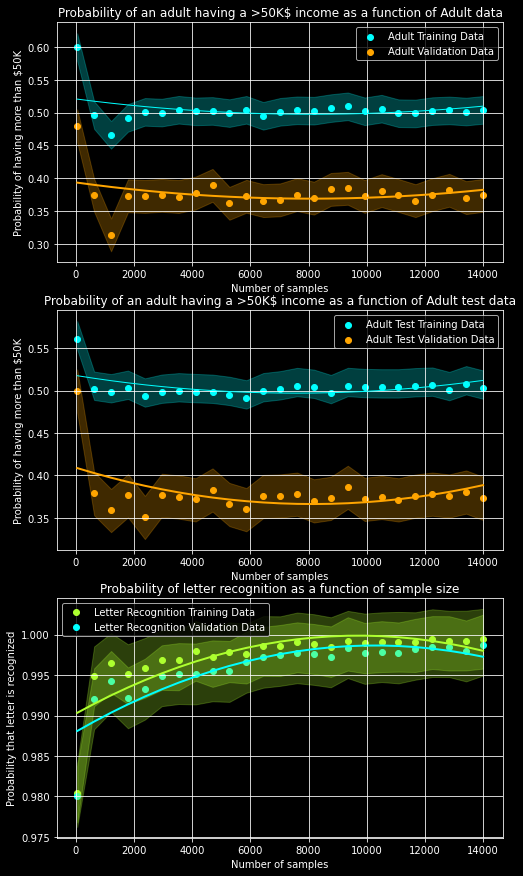

In [11]:
t = samples

# Adult data
adult_tr_std = np.std(adult_tr_results)
adult_vl_std = np.std(adult_vl_results)
# Adult test
adult_test_tr_std = np.std(adult_test_tr_results)
adult_test_vl_std = np.std(adult_test_vl_results)
# Letter data
letters_tr_std = np.std(letters_tr_results)
letters_vl_std = np.std(letters_vl_results)
# polyfit
a0, a1, a2 = np.polyfit(t, adult_tr_results, deg=2)
b0, b1, b2 = np.polyfit(t, adult_vl_results, deg=2)
c0, c1, c2 = np.polyfit(t, adult_test_tr_results, deg=2)
d0, d1, d2 = np.polyfit(t, adult_test_vl_results, deg=2)
e0, e1, e2 = np.polyfit(t, letters_tr_results, deg=2)
f0, f1, f2 = np.polyfit(t, letters_vl_results, deg=2)

fun0 = a0*np.power(t,2) + a1*np.power(t,1) + a2*np.power(t,0)
fun1 = b0*np.power(t,2) + b1*np.power(t,1) + b2*np.power(t,0)
fun2 = c0*np.power(t,2) + c1*np.power(t,1) + c2*np.power(t,0)
fun3 = d0*np.power(t,2) + d1*np.power(t,1) + d2*np.power(t,0)
fun4 = e0*np.power(t,2) + e1*np.power(t,1) + e2*np.power(t,0)
fun5 = f0*np.power(t,2) + f1*np.power(t,1) + f2*np.power(t,0)

fig = plt.figure(figsize=(8,15))
fig.tight_layout(pad=5.0)
ax0, ax1, ax2 = fig.subplots(3)

ax0.set_title("Probability of an adult having a >50K$ income as a function of Adult data")
ax0.grid()
ax0.set_xlabel('Number of samples')
ax0.set_ylabel('Probability of having more than $50K')

ax0.scatter(t, adult_tr_results, c='cyan', 
           label='Adult Training Data' )
ax0.scatter(t, adult_vl_results, c='orange',
           label='Adult Validation Data')
ax0.plot(t,fun0, linewidth=1, color='cyan')
ax0.plot(t,fun1, linewidth=2, color='orange')

ax0.fill_between(t, adult_tr_results-adult_tr_std, adult_tr_results+adult_tr_std, alpha=0.25, color='cyan')
ax0.fill_between(t, adult_vl_results-adult_vl_std, adult_vl_results+adult_vl_std, alpha=0.25, color='orange')
ax0.legend()

ax1.set_title("Probability of an adult having a >50K$ income as a function of Adult test data")
ax1.grid()
ax1.set_xlabel('Number of samples')
ax1.set_ylabel('Probability of having more than $50K')

ax1.scatter(t, adult_test_tr_results, c='cyan', 
           label='Adult Test Training Data' )
ax1.scatter(t, adult_test_vl_results, c='orange',
           label='Adult Test Validation Data')
ax1.plot(t,fun2, linewidth=1, color='cyan')
ax1.plot(t,fun3, linewidth=2, color='orange')

ax1.fill_between(t, adult_test_tr_results-adult_test_tr_std, adult_test_tr_results+adult_tr_std, alpha=0.25, color='cyan')
ax1.fill_between(t, adult_test_vl_results-adult_test_vl_std, adult_test_vl_results+adult_vl_std, alpha=0.25, color='orange')
ax1.legend()

ax2.set_title("Probability of letter recognition as a function of sample size")
ax2.grid()
ax2.scatter(t, letters_tr_results, c='greenyellow',
           label='Letter Recognition Training Data')
ax2.scatter(t, letters_vl_results, c='cyan',
           label='Letter Recognition Validation Data')
ax2.legend()
ax2.set_xlabel('Number of samples')
ax2.set_ylabel('Probability that letter is recognized')

ax2.plot(t,fun4, linewidth=2, color='greenyellow')
ax2.plot(t,fun5, linewidth=2, color='cyan')
ax2.fill_between(t, letters_tr_results-letters_tr_std, letters_tr_results+letters_tr_std, alpha=0.25, color='greenyellow')
ax2.fill_between(t, letters_vl_results-letters_vl_std, letters_vl_results+letters_vl_std, alpha=0.25, color='greenyellow')